In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn import preprocessing
import seaborn as sns
from sklearn.decomposition import PCA 

import matplotlib.pyplot as plt

from scipy import sparse
from scipy.cluster.hierarchy import cophenet, fcluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df_original = pd.read_csv('../../sample_data_2017_M4_cleaned.csv')

In [3]:
df_990 = df_original[df_original['FormType'] == '990']
df_990EZ = df_original[df_original['FormType'] == '990EZ']
df_990 = df_990.drop(['FormType'], axis = 1)
df_990EZ = df_990EZ.drop(['FormType'], axis = 1)
df_990EZ = df_990EZ.dropna(how = "all", axis = 1)

df_990EZ = df_990EZ.fillna(0)
df_990 = df_990.fillna(0)

In [4]:
def standardize(df):
    eins = list(df['EIN'])
#     df = df.fillna(0)
    cols = df.loc[:, df.columns != 'EIN'].columns
    df = pd.DataFrame(preprocessing.scale(df.loc[:, df.columns != 'EIN']))
    df.columns = cols
    df['EIN'] = eins
    return df

In [5]:
df_990 = standardize(df_990)
df_990EZ = standardize(df_990EZ)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


In [6]:
def PCA_components(df):
    pca = PCA()
    pca.fit(df.loc[:, df.columns != 'EIN'])
    df_pca = pca.transform(df.loc[:, df.columns != 'EIN'])
    var = pca.explained_variance_ratio_
    var_cumsum = np.cumsum(var)
    comp = range(1, len(var)+1)

    %matplotlib inline
    plt.plot(comp,var_cumsum)
    plt.xlabel('Components')
    plt.ylabel('% Variance')
    plt.title('Variance explained by each component')
    print(var_cumsum)

In [7]:
def fit_pca(df, n):
    eins = list(df['EIN'])
    pca = PCA(n_components = n)
    pca.fit(df.loc[:, df.columns != 'EIN'])
    df_pca = pca.transform(df.loc[:, df.columns != 'EIN'])
    df_pca = pd.DataFrame(df_pca)
    df_pca['EIN'] = eins
    return df_pca

In [8]:
import os
import pickle

def save_pickle(data, path):
    with open(path, 'wb') as handle:
        pickle.dump(data, handle)

def load_pickle(path):
    with open(path, 'rb') as handle:
        return pickle.load(handle)

def handle_pickle(path):
    if os.path.exists(path):
        return load_pickle(path)
    else:
        return None

In [9]:
#------------------------------------------------------------------------------#
def fancy_dendrogram(*args, **kwargs):
    
    # Parse max_d
    max_d = kwargs.pop('max_d', None)
    
    # Set color_threshold
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    
    # Parse annotate_above
    annotate_above = kwargs.pop('annotate_above', 0)
    
    # Create dendrogram object
    dd = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        
        for i, d, c in zip(dd['icoord'], dd['dcoord'], dd['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        
        # Plot horizontal line if specified
        if max_d:
            plt.axhline(y=max_d, c='k')
    
    return dd


def get_wcv(clusters, means):
    """
    Function for calculating the within-cluster variance values for an input set
    of clusters and respective means
    """
    K = len(means)
    
    wcv = 0
    for i in range(K):
        for c in clusters[i]:
            wcv += np.linalg.norm(c-means[i])**2

    return wcv


def group_clusters(X, labels):
    """
    Function for separating a dataset and cluster labels into cluster groups 
    based and calculating within-cluster means
    """
    unique_labels = np.unique(labels)
    
    groups = []
    means = []
    
    for label in unique_labels:
        label_idx = np.where(labels==label)[0]
        x_subset = X[label_idx]
        
        # Update groups and means
        groups.append(x_subset)
        means.append(np.average(x_subset, axis=0))
    
    return groups, np.array(means).reshape((len(unique_labels),-1))


def bounding_box(X):
    """
    Function for getting min-max coordinates for drawing bounding box for gap
    statistics calculation
    """
    min_max = []
    for i in range(X.shape[-1]):
        min_max.append((np.min(X[:,i]), np.max(X[:, i])))
    return min_max
    

def gap_statistics(Z, X, C=500):
    """
    Helper function for applying a gap statistics calculation over an input 
    dataset to find the optimum number of clusters
    
    Input(s):
    - Z (numpy ndarray): linkage array from scipy's "linkage" function
    - X (numpy ndarary): transformed dataset
    - C (          int): number of clusters (default: 500)
    
    Output(s):
    -   scan_range: range of cluster values scanned
    -     wcv_list: within-cluster variances for the range of scanned clusters
    - uni_wcv_list: within-cluster variances for reference uniform datasets
    -  uni_std_err: standard error for reference uniform datasets
    """
    N = X.shape[0]
    
    MAX_CLUSTERS = C
    NUM_UNI = 10
    
    # Get bounding box min-max values
    min_max = bounding_box(X)
    
    scan_range = np.arange(1, MAX_CLUSTERS+1)
    wcv_list = np.zeros(MAX_CLUSTERS)
    uni_wcv_list = np.zeros(MAX_CLUSTERS)
    uni_std_err = np.zeros(MAX_CLUSTERS)
    
    # Iterate through 
    for idx, k in enumerate(scan_range):
        print('Scanning: %d'%k)
        
        # Get cluster labels
        labels = fcluster(Z, k, criterion='maxclust')
        
        # Parse dataset into clusters and calculate WCV
        clusters, means = group_clusters(X, labels)
        wcv_list[idx] = np.log(get_wcv(clusters, means))
        
        # Create reference uniform clusters
        wcv_B = np.zeros(NUM_UNI)
        for i in range(NUM_UNI):
            x_uniform = np.zeros((N, len(min_max)))
            for j, mm in enumerate(min_max):
                x_uniform[:, j] = np.random.uniform(mm[0], mm[-1], N)
            
            # Parse reference dataset and calculate WCV
            uni_clusters, uni_means = group_clusters(x_uniform, labels)
            wcv_B[i] = np.log(get_wcv(uni_clusters, uni_means))
        
        # Update uniform WCV list and uniform standard error
        uni_wcv_list[idx] = sum(wcv_B)/NUM_UNI
        uni_std_err[idx] = np.sqrt(sum((wcv_B-uni_wcv_list[idx])**2)/NUM_UNI)
    
    # Group update to standard errors
    uni_std_err = uni_std_err*np.sqrt(1+1/NUM_UNI)
    
    return scan_range, wcv_list, uni_wcv_list, uni_std_err


def best_cluster(ks, logWs, logBWs, stderr, MAX_CLUSTERS = 500):
    """
    Locates the best cluster using calculated gap statistic components
    """
    # Calculate complete gap statistic
    gap = logBWs - logWs
    
    k0 = gap[:-1]
    k1 = gap[1:]
    s1 = stderr[1:]
    
    # Calculate criteria
    criteria = (k0 >= (k1-s1))
    
    try:
        crit_idx = np.where(criteria==True)[0]
        return crit_idx[0]+1 # Offset start-at-0 counting
    
    except:
        return MAX_CLUSTERS
#------------------------------------------------------------------------------#

In [14]:
sample = df_990.sample(frac=0.7, random_state=0)

[0.26950843 0.41338539 0.54099611 0.64351712 0.7448008  0.83846336
 0.90186306 0.93087134 0.95914049 0.97729686 0.9924778  0.99736312
 0.9994666  0.99970321 0.99984595 0.99991926 0.99997406 1.
 1.        ]


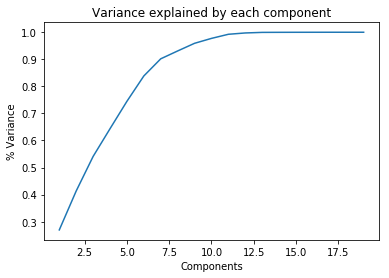

In [15]:
PCA_components(sample)

In [16]:
df_reduced = fit_pca(sample, 9)

In [17]:
x_reduced = df_reduced.values
x_reduced.shape

(44949, 10)

In [18]:
x_reduced[:,:-1].shape ## exclude EIN

(44949, 9)

In [19]:
linkage_save = './linkage.pickle'

# Get linkage matrix
Z = handle_pickle(linkage_save)

if type(Z)==type(None):
    Z = linkage(x_reduced[:,:-1], method='ward')
    save_pickle(Z, linkage_save)
    
print(Z.shape)

# Z = linkage(x_reduced[:,:-1], method='ward')

(44948, 4)


In [20]:
gap_metrics_save = './gap_metrics.pickle'

gap_metrics = handle_pickle(gap_metrics_save)

# Calculate gap statistic
if type(gap_metrics)==type(None):
    ks, logWs, logBWs, stderr = gap_statistics(Z, x_reduced[:,:-1])
    gap_metrics = {
        'ks': ks,
        'logWs': logWs,
        'logBWs': logBWs,
        'stderr': stderr
    }
    save_pickle(gap_metrics, gap_metrics_save)

ks = gap_metrics['ks']
logWs = gap_metrics['logWs']
logBWs = gap_metrics['logBWs']
stderr = gap_metrics['stderr']

Scanning: 1
Scanning: 2
Scanning: 3
Scanning: 4
Scanning: 5
Scanning: 6
Scanning: 7
Scanning: 8
Scanning: 9
Scanning: 10
Scanning: 11
Scanning: 12
Scanning: 13
Scanning: 14
Scanning: 15
Scanning: 16
Scanning: 17
Scanning: 18
Scanning: 19
Scanning: 20
Scanning: 21
Scanning: 22
Scanning: 23
Scanning: 24
Scanning: 25
Scanning: 26
Scanning: 27
Scanning: 28
Scanning: 29
Scanning: 30
Scanning: 31
Scanning: 32
Scanning: 33
Scanning: 34
Scanning: 35
Scanning: 36
Scanning: 37
Scanning: 38
Scanning: 39
Scanning: 40
Scanning: 41
Scanning: 42
Scanning: 43
Scanning: 44
Scanning: 45
Scanning: 46
Scanning: 47
Scanning: 48
Scanning: 49
Scanning: 50
Scanning: 51
Scanning: 52
Scanning: 53
Scanning: 54
Scanning: 55
Scanning: 56
Scanning: 57
Scanning: 58
Scanning: 59
Scanning: 60
Scanning: 61
Scanning: 62
Scanning: 63
Scanning: 64
Scanning: 65
Scanning: 66
Scanning: 67
Scanning: 68
Scanning: 69
Scanning: 70
Scanning: 71
Scanning: 72
Scanning: 73
Scanning: 74
Scanning: 75
Scanning: 76
Scanning: 77
Scanning

In [21]:
# Get best cluster labels
bc = best_cluster(ks, logWs, logBWs, stderr)
print('\nBest cluster size:', bc)
clusters = fcluster(Z, bc, criterion='maxclust')


Best cluster size: 500


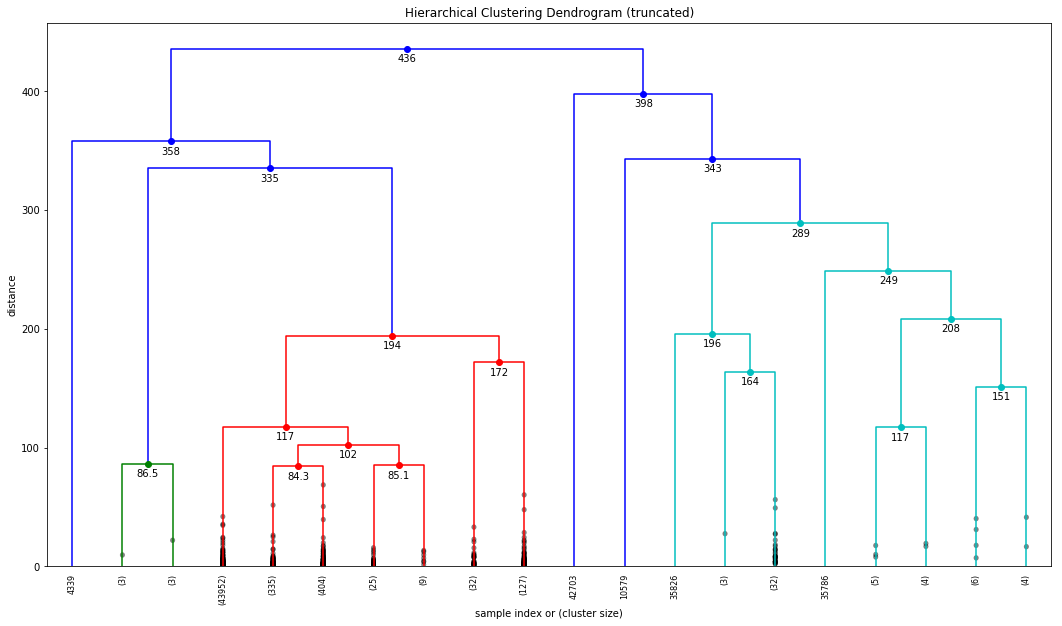

In [22]:
# Plot dendrogram
plt.figure(figsize=(18, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()

In [37]:
cluster_size = 500
clusters = fcluster(Z, cluster_size, criterion='maxclust')
sample['cluster'] = clusters

In [38]:
counts = list(sample.groupby('cluster').count()['EIN'])

In [39]:
max(counts)

19404

### Partition by GrossReceiptsAmt

In [41]:
for p in [0.25, 0.5, 0.75, 0.9]:
    print(str(p) + '%: ' + str(sample['GrossReceiptsAmt'].quantile(p)))

0.25%: -0.031069700791049547
0.5%: -0.030477928249062803
0.75%: -0.027805395138727974
0.9%: -0.014423657907222689


In [43]:
df0 = sample[sample['GrossReceiptsAmt'] < -0.03]
df1 = sample[sample['GrossReceiptsAmt'] > -0.03]
df1 = df1[df1['GrossReceiptsAmt'] < -0.02]
df2 = sample[sample['GrossReceiptsAmt'] >= -0.02]
df2 = df2[df2['GrossReceiptsAmt'] < -0.01]
df3 = sample[sample['GrossReceiptsAmt'] >= -0.01]

print(len(sample) == len(df0) + len(df1) + len(df2) + len(df3))
print(len(df0), len(df1), len(df2), len(df3))

True
26469 12653 2010 3817


[0.99929133 0.99984888 0.99993378 0.99995847 0.99997476 0.99998646
 0.99999203 0.99999621 0.99999872 0.99999936 0.99999961 0.99999975
 0.99999984 0.9999999  0.99999994 0.99999996 0.99999998 1.
 1.         1.        ]


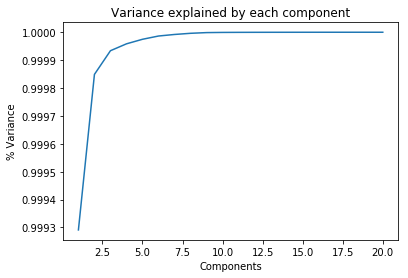

In [48]:
# PCA_components(df0) # 3 components
# PCA_components(df1) # 3 components
# PCA_components(df2) # 3 components
# PCA_components(df3) # 3 components

In [51]:
d0_pca = fit_pca(df0, 3)
d1_pca = fit_pca(df1, 3)
d2_pca = fit_pca(df2, 3)
d3_pca = fit_pca(df3, 3)

x0_reduced = d0_pca.values
x1_reduced = d1_pca.values
x2_reduced = d2_pca.values
x3_reduced = d3_pca.values

In [53]:
Z0 = linkage(x0_reduced[:,:-1], method='ward')
print(Z0.shape)
Z1 = linkage(x1_reduced[:,:-1], method='ward')
print(Z1.shape)
Z2 = linkage(x2_reduced[:,:-1], method='ward')
print(Z2.shape)
Z3 = linkage(x3_reduced[:,:-1], method='ward')
print(Z3.shape)

(26468, 4)
(12652, 4)
(2009, 4)
(3816, 4)


In [54]:
ks, logWs, logBWs, stderr = gap_statistics(Z0, x0_reduced[:,:-1])
gap_metrics0 = {
    'ks': ks,
    'logWs': logWs,
    'logBWs': logBWs,
    'stderr': stderr
}
print(gap_metrics0)

ks, logWs, logBWs, stderr = gap_statistics(Z1, x1_reduced[:,:-1])
gap_metrics1 = {
    'ks': ks,
    'logWs': logWs,
    'logBWs': logBWs,
    'stderr': stderr
}
print(gap_metrics1)

ks, logWs, logBWs, stderr = gap_statistics(Z2, x2_reduced[:,:-1])
gap_metrics2 = {
    'ks': ks,
    'logWs': logWs,
    'logBWs': logBWs,
    'stderr': stderr
}
print(gap_metrics2)

ks, logWs, logBWs, stderr = gap_statistics(Z3, x3_reduced[:,:-1])
gap_metrics3 = {
    'ks': ks,
    'logWs': logWs,
    'logBWs': logBWs,
    'stderr': stderr
}
print(gap_metrics3)

Scanning: 1
Scanning: 2
Scanning: 3
Scanning: 4
Scanning: 5
Scanning: 6
Scanning: 7
Scanning: 8
Scanning: 9
Scanning: 10
Scanning: 11
Scanning: 12
Scanning: 13
Scanning: 14
Scanning: 15
Scanning: 16
Scanning: 17
Scanning: 18
Scanning: 19
Scanning: 20
Scanning: 21
Scanning: 22
Scanning: 23
Scanning: 24
Scanning: 25
Scanning: 26
Scanning: 27
Scanning: 28
Scanning: 29
Scanning: 30
Scanning: 31
Scanning: 32
Scanning: 33
Scanning: 34
Scanning: 35
Scanning: 36
Scanning: 37
Scanning: 38
Scanning: 39
Scanning: 40
Scanning: 41
Scanning: 42
Scanning: 43
Scanning: 44
Scanning: 45
Scanning: 46
Scanning: 47
Scanning: 48
Scanning: 49
Scanning: 50
Scanning: 51
Scanning: 52
Scanning: 53
Scanning: 54
Scanning: 55
Scanning: 56
Scanning: 57
Scanning: 58
Scanning: 59
Scanning: 60
Scanning: 61
Scanning: 62
Scanning: 63
Scanning: 64
Scanning: 65
Scanning: 66
Scanning: 67
Scanning: 68
Scanning: 69
Scanning: 70
Scanning: 71
Scanning: 72
Scanning: 73
Scanning: 74
Scanning: 75
Scanning: 76
Scanning: 77
Scanning

Scanning: 2
Scanning: 3
Scanning: 4
Scanning: 5
Scanning: 6
Scanning: 7
Scanning: 8
Scanning: 9
Scanning: 10
Scanning: 11
Scanning: 12
Scanning: 13
Scanning: 14
Scanning: 15
Scanning: 16
Scanning: 17
Scanning: 18
Scanning: 19
Scanning: 20
Scanning: 21
Scanning: 22
Scanning: 23
Scanning: 24
Scanning: 25
Scanning: 26
Scanning: 27
Scanning: 28
Scanning: 29
Scanning: 30
Scanning: 31
Scanning: 32
Scanning: 33
Scanning: 34
Scanning: 35
Scanning: 36
Scanning: 37
Scanning: 38
Scanning: 39
Scanning: 40
Scanning: 41
Scanning: 42
Scanning: 43
Scanning: 44
Scanning: 45
Scanning: 46
Scanning: 47
Scanning: 48
Scanning: 49
Scanning: 50
Scanning: 51
Scanning: 52
Scanning: 53
Scanning: 54
Scanning: 55
Scanning: 56
Scanning: 57
Scanning: 58
Scanning: 59
Scanning: 60
Scanning: 61
Scanning: 62
Scanning: 63
Scanning: 64
Scanning: 65
Scanning: 66
Scanning: 67
Scanning: 68
Scanning: 69
Scanning: 70
Scanning: 71
Scanning: 72
Scanning: 73
Scanning: 74
Scanning: 75
Scanning: 76
Scanning: 77
Scanning: 78
Scannin

Scanning: 3
Scanning: 4
Scanning: 5
Scanning: 6
Scanning: 7
Scanning: 8
Scanning: 9
Scanning: 10
Scanning: 11
Scanning: 12
Scanning: 13
Scanning: 14
Scanning: 15
Scanning: 16
Scanning: 17
Scanning: 18
Scanning: 19
Scanning: 20
Scanning: 21
Scanning: 22
Scanning: 23
Scanning: 24
Scanning: 25
Scanning: 26
Scanning: 27
Scanning: 28
Scanning: 29
Scanning: 30
Scanning: 31
Scanning: 32
Scanning: 33
Scanning: 34
Scanning: 35
Scanning: 36
Scanning: 37
Scanning: 38
Scanning: 39
Scanning: 40
Scanning: 41
Scanning: 42
Scanning: 43
Scanning: 44
Scanning: 45
Scanning: 46
Scanning: 47
Scanning: 48
Scanning: 49
Scanning: 50
Scanning: 51
Scanning: 52
Scanning: 53
Scanning: 54
Scanning: 55
Scanning: 56
Scanning: 57
Scanning: 58
Scanning: 59
Scanning: 60
Scanning: 61
Scanning: 62
Scanning: 63
Scanning: 64
Scanning: 65
Scanning: 66
Scanning: 67
Scanning: 68
Scanning: 69
Scanning: 70
Scanning: 71
Scanning: 72
Scanning: 73
Scanning: 74
Scanning: 75
Scanning: 76
Scanning: 77
Scanning: 78
Scanning: 79
Scanni

Scanning: 2
Scanning: 3
Scanning: 4
Scanning: 5
Scanning: 6
Scanning: 7
Scanning: 8
Scanning: 9
Scanning: 10
Scanning: 11
Scanning: 12
Scanning: 13
Scanning: 14
Scanning: 15
Scanning: 16
Scanning: 17
Scanning: 18
Scanning: 19
Scanning: 20
Scanning: 21
Scanning: 22
Scanning: 23
Scanning: 24
Scanning: 25
Scanning: 26
Scanning: 27
Scanning: 28
Scanning: 29
Scanning: 30
Scanning: 31
Scanning: 32
Scanning: 33
Scanning: 34
Scanning: 35
Scanning: 36
Scanning: 37
Scanning: 38
Scanning: 39
Scanning: 40
Scanning: 41
Scanning: 42
Scanning: 43
Scanning: 44
Scanning: 45
Scanning: 46
Scanning: 47
Scanning: 48
Scanning: 49
Scanning: 50
Scanning: 51
Scanning: 52
Scanning: 53
Scanning: 54
Scanning: 55
Scanning: 56
Scanning: 57
Scanning: 58
Scanning: 59
Scanning: 60
Scanning: 61
Scanning: 62
Scanning: 63
Scanning: 64
Scanning: 65
Scanning: 66
Scanning: 67
Scanning: 68
Scanning: 69
Scanning: 70
Scanning: 71
Scanning: 72
Scanning: 73
Scanning: 74
Scanning: 75
Scanning: 76
Scanning: 77
Scanning: 78
Scannin

In [55]:
# Get best cluster labels
bc0 = best_cluster(gap_metrics0['ks'], gap_metrics0['logWs'], gap_metrics0['logBWs'], gap_metrics0['stderr'])
print('\nBest cluster size:', bc0)
bc1 = best_cluster(gap_metrics1['ks'], gap_metrics1['logWs'], gap_metrics1['logBWs'], gap_metrics1['stderr'])
print('\nBest cluster size:', bc1)
bc2 = best_cluster(gap_metrics2['ks'], gap_metrics2['logWs'], gap_metrics2['logBWs'], gap_metrics2['stderr'])
print('\nBest cluster size:', bc2)
bc3 = best_cluster(gap_metrics3['ks'], gap_metrics3['logWs'], gap_metrics3['logBWs'], gap_metrics3['stderr'])
print('\nBest cluster size:', bc3)


Best cluster size: 201

Best cluster size: 201

Best cluster size: 189

Best cluster size: 89


In [56]:
clusters0 = fcluster(Z0, bc0, criterion='maxclust')
clusters1 = fcluster(Z1, bc1, criterion='maxclust')
clusters2 = fcluster(Z2, bc2, criterion='maxclust')
clusters3 = fcluster(Z3, bc3, criterion='maxclust')

df0['labels'] = clusters0
df1['labels'] = clusters1
df2['labels'] = clusters2
df3['labels'] = clusters3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [57]:
counts0 = list(df0.groupby('labels').count()['EIN'])
counts1 = list(df1.groupby('labels').count()['EIN'])
counts2 = list(df2.groupby('labels').count()['EIN'])
counts3 = list(df3.groupby('labels').count()['EIN'])

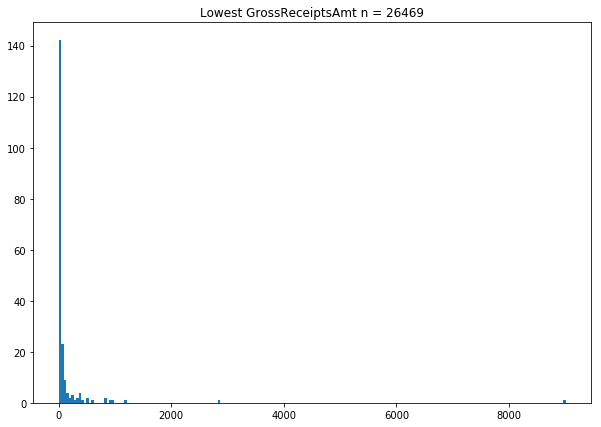

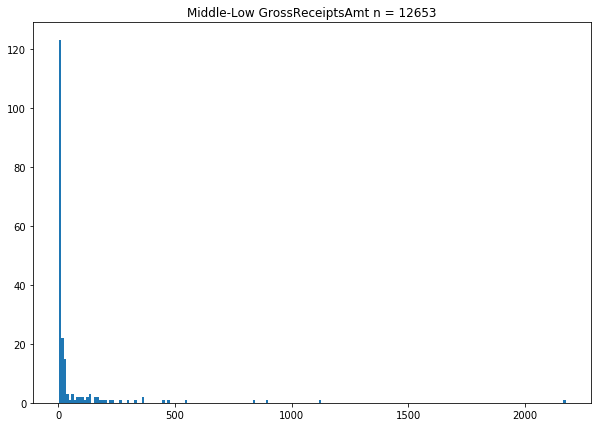

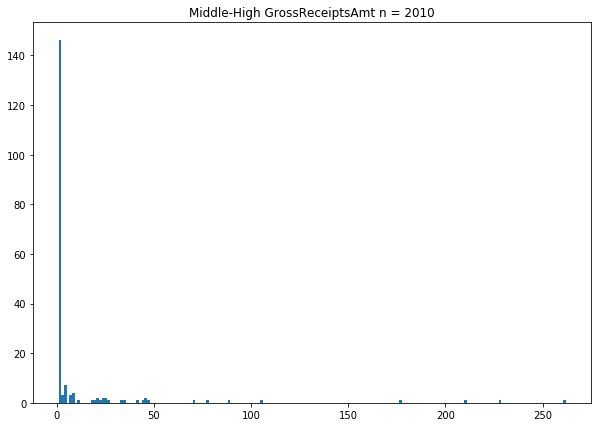

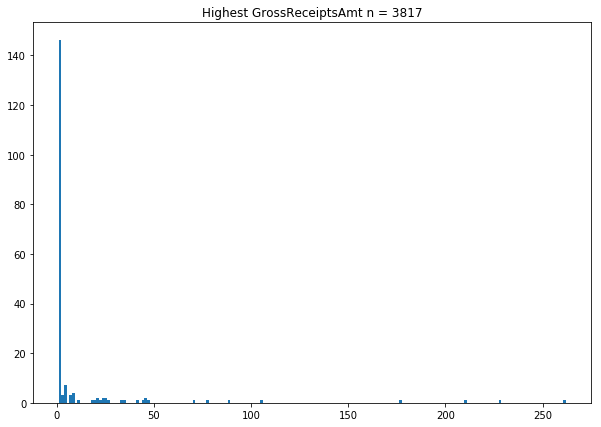

In [66]:
plt.figure(figsize=(10,7))
plt.hist(counts0, bins = bc0)
plt.title('Lowest GrossReceiptsAmt' + ' n = ' + str(len(df0)))
plt.show()

plt.figure(figsize=(10,7))
plt.hist(counts1, bins = bc1)
plt.title('Middle-Low GrossReceiptsAmt' + ' n = ' + str(len(df1)))
plt.show()

plt.figure(figsize=(10,7))
plt.hist(counts2, bins = bc2)
plt.title('Middle-High GrossReceiptsAmt' + ' n = ' + str(len(df2)))
plt.show()

plt.figure(figsize=(10,7))
plt.hist(counts2, bins = bc2)
plt.title('Highest GrossReceiptsAmt' + ' n = ' + str(len(df3)))
plt.show()

In [77]:
df0['model_group'] = 0
df1['model_group'] = 1
df2['model_group'] = 2
df3['model_group'] = 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [78]:
df = df0.append(df1)
df = df.append(df2)
df = df.append(df3)

In [81]:
df = df.drop(['cluster'], axis=1)

In [82]:
df.tail()

,CYSalariesCompEmpBnftPaidAmt,CYTotalExpensesAmt,CYTotalProfFndrsngExpnsAmt,CYTotalRevenueAmt,GovernmentGrantsAmt,GrossReceiptsAmt,OtherSalariesAndWagesGrp/TotalAmt,PYSalariesCompEmpBnftPaidAmt,PYTotalExpensesAmt,PYTotalProfFndrsngExpnsAmt,...,RevenueAmt,TotalAssetsGrp/EOYAmt,TotalContributionsAmt,TotalEmployeeCnt,TotalLiabilitiesGrp/EOYAmt,TotalNetAssetsFundBalanceGrp/EOYAmt,TotalVolunteersCnt,EIN,labels,model_group
25717,-0.065366,0.084559,-0.046473,0.071784,-0.063516,0.118940,-0.062908,-0.064210,0.085709,-0.043557,...,-0.031938,0.194768,-0.095150,-0.011068,-0.034249,0.416245,-0.004933,350851694,59,3
29997,0.108161,0.143499,-0.046473,0.132526,-0.051110,0.045802,0.079005,0.121835,0.135469,-0.043557,...,0.124067,0.115361,0.157916,0.566275,0.131763,0.033152,-0.003667,391049688,49,3
1577,0.019342,0.017990,-0.046473,0.015403,2.089664,-0.004591,0.024576,0.018096,0.018179,-0.043557,...,-0.031938,-0.040924,0.905601,0.005687,-0.029632,-0.035773,-0.003778,42512171,11,3
24261,-0.051040,0.004929,-0.046473,0.002813,-0.063516,-0.009836,-0.046388,-0.049226,0.011855,-0.043557,...,0.010901,-0.040378,0.088221,-0.017660,-0.026669,-0.038899,-0.002325,330826474,88,3
57123,0.110950,0.007182,-0.046473,0.005184,1.612929,-0.008851,0.114323,0.127923,0.011766,-0.043557,...,-0.031938,-0.005125,0.610120,0.108411,-0.033213,0.036924,-0.004933,850213360,12,3


In [83]:
df.to_csv('./sample_data_2017_M4_990_labels.csv', index=False)